In [1]:
import pandas as pd
import numpy as np
import dill
import matplotlib.pyplot as plt
import time
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib
from sklearn.metrics import roc_curve, auc,confusion_matrix, f1_score, auc

from jupyterthemes import jtplot

# currently installed theme will be used to
# set plot style if no arguments provided
#jtplot.style()
# You do not need any more imports 
%matplotlib inline

In [8]:
# Load test data 
# Data should be fixed and saved
test_X = np.load('Data/test_x.npy').item()
tesy_y = np.load('Data/test_y.npy')

In [9]:
config = eval(open( '../config.json').read())
model_name = config['Model name']

In [10]:
# Load model
clf = joblib.load('model/{}'.format(model_name))
print("Loaded model")

Loaded model


In [11]:
# probability of class 1
preds = clf.predict_proba(test_X)[:,1]

In [12]:
preds

array([0.85541102, 0.9881711 , 0.14340534, ..., 0.17454978, 0.97379411,
       0.00802728])

In [13]:
def max_f1(prob_preds, labels):
    """
    Finds the threshold of classification that maximizes the F1 Metric
    
    Arguments: 
    prob_preds -- numpy array of probability scores 
    labels -- ground truth labels
    
    Return:
    cutoff -- Cutoff that maximizes the F1 metric
    max_f1 -- maximal value for the f1 metric
    """
    cutoff = 0
    max_f1 = 0
    for i in prob_preds:
        preds = prob_preds > i
        tmp_score = f1_score(labels, preds)
        if tmp_score > max_f1:
            max_f1 = tmp_score
            cutoff = i
    return cutoff, max_f1

def find_closest_index(cutoff, thresholds):
    """
    Finds the threshold closest to the cutoff. 
    
    Arguments:
    cutoff -- scalar cutoff value
    threshholds -- list of all unique probabilities 
    TODO: implement this using Binary Search. YA boy is lazy. 
    
    Return:
    best_index -- index of thresholds that has a value closest to cutoff
    TODO: Implement with binary search. 
    """
    best_index = -1
    min_dist = 9999999
    for i in range(len(thresholds)):
        tmp = abs(cutoff - thresholds[i])
        if tmp < min_dist:
            min_dist = tmp
            best_index = i
    return best_index



cm_cols = ["Predicited Negative", "Predicted Positive"]
cm_index = ["Negative", "Positive"]

def plot_roc( prob_preds, Y,cutoff=.5):
    fpr, tpr, thresholds = roc_curve(Y, prob_preds)
    AUC = auc(fpr,tpr)
    cutoff_index = find_closest_index(cutoff, thresholds)
    print("Closest threshold is", thresholds[cutoff_index])
    print("For threshold of: " ,thresholds[cutoff_index], 'FPR:', fpr[cutoff_index], "TPR:", tpr[cutoff_index])
    fig = plt.figure(figsize=(8,8))
    plt.plot(fpr,tpr)
    plt.title("ROC curve with AUC={}".format( round(AUC,4) ), fontsize=18)
    plt.plot([0,1],'r--') 
    plt.scatter(fpr[cutoff_index],tpr[cutoff_index], marker='x',s=200, c='r')
    preds = np.array(prob_preds) >= cutoff
    preds = preds.astype(int)
    cm = confusion_matrix(Y, preds)
    f1 = f1_score(Y, preds)
    cm_df = pd.DataFrame(cm, index=cm_index, columns=cm_cols)
    print('F1-score',f1)
    print()
    print(cm_df)
    plt.xlabel("False Positive Rate", fontsize=18)
    plt.ylabel("True Positive rate",fontsize=18)
    plt.savefig("ROC.png",transparent=True )

Closest threshold is 0.4999805944555582
For threshold of:  0.4999805944555582 FPR: 0.18951819579702717 TPR: 0.8342728297632469
F1-score 0.8261274114509025

          Predicited Negative  Predicted Positive
Negative                 6325                1479
Positive                 1324                6659


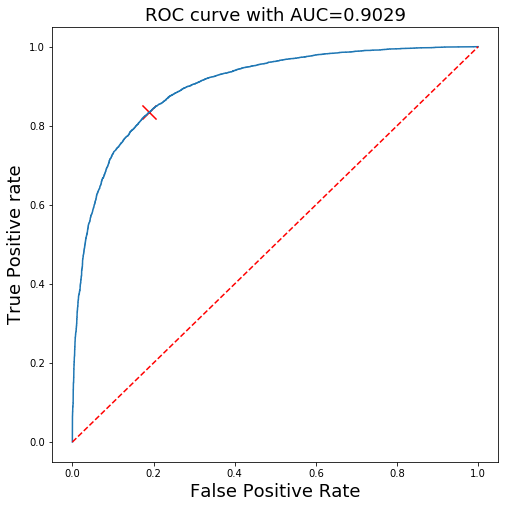

In [14]:
plot_roc(preds,tesy_y)